In [ ]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg
from pyspark.sql.types import DateType, TimestampType
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import Imputer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc

import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import os
memory = '4g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#sc = SparkContext()  
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.driver.memory', '4g')

spark_conf = SparkConf().setAll(pairs = [('spark.executor.memory', '4g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','4g')])

spark = SparkSession.builder.config("spark.sql.warehouse.dir", "file:///C:/temp").appName("SparkSQL").getOrCreate()
sqlContext = SQLContext(spark)

spark.sparkContext.setLogLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')


### Load Data to Spark DataFrame

In [ ]:
loanDF = spark.read.load('file:///home/hrithikdiwakar/Desktop/loans_big_data_project/loans.csv',
                     format="csv", sep=",", inferSchema='true', header="true")
loanDF.printSchema()


root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

### Find the Feature columns which has more than 50% empty data

In [ ]:
# find list of columns which has more than 50% of data missing.
def findMissingValueCols(df):
    #df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    missingValueColumns = []
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        print(column, "--", nullRows)
        if nullRows > loanDFRows*0.5 : # i.e. if ALL values are NULL
            missingValueColumns.append(column)
    return missingValueColumns

### Loan Counts group by loan_status

In [ ]:
#categorizing the types of loans with their counts

loanDF.groupBy('loan_status').count().sort("count", ascending=False).show()


+--------------------+------+
|         loan_status| count|
+--------------------+------+
|             Current|601776|
|          Fully Paid|207533|
|         Charged Off| 45215|
|  Late (31-120 days)| 11591|
|              Issued|  8460|
|     In Grace Period|  6253|
|   Late (16-30 days)|  2357|
|Does not meet the...|  1969|
|             Default|  1219|
|Does not meet the...|   751|
+--------------------+------+



### Alalyzing Loans over loan status.

- Number of loans over for each loan status
- Distribution of total accounts for each status
- Distribution of loan amount with the probability density for each loan value over loan status

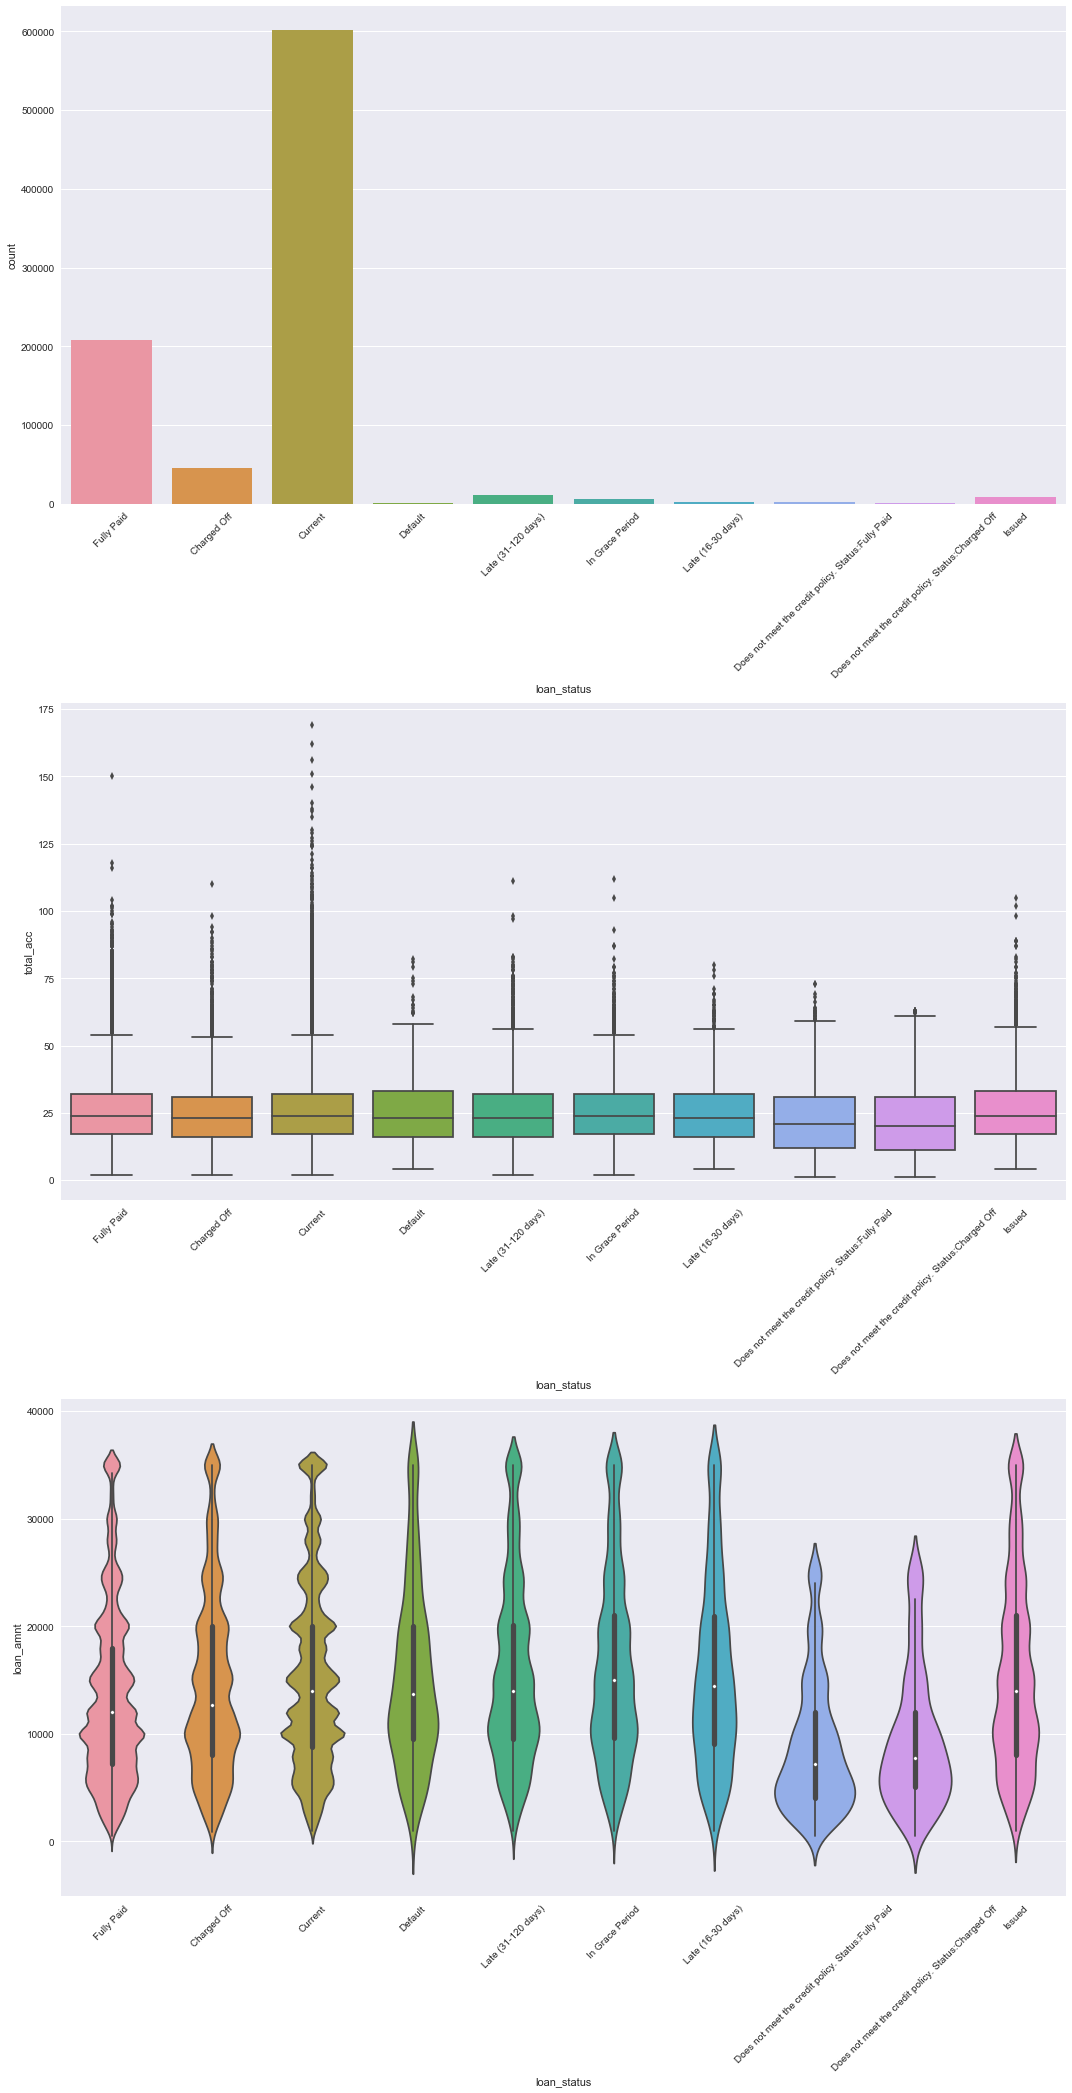

In [ ]:
loanDF = loanDF.withColumn("total_acc",loanDF["total_acc"].cast('float'))

tmp = loanDF.select("loan_status", "total_acc", "loan_amnt").toPandas()

fig, ax =plt.subplots(3,1,figsize=(18,30))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="loan_status", data=tmp,ax=ax[0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

s1 = sns.boxplot(x="loan_status", y="total_acc", data=tmp,ax=ax[1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)



s2 = sns.violinplot(x="loan_status", y="loan_amnt", data=tmp,ax=ax[2] , estimator=sum)
s2.set_xticklabels(s2.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("LoanOveroanStatus.pdf")

#### Analyzing interest rate distribution for each grade, factored over sub grade.

This shows the interest rates goes high for low credit rating customers. 

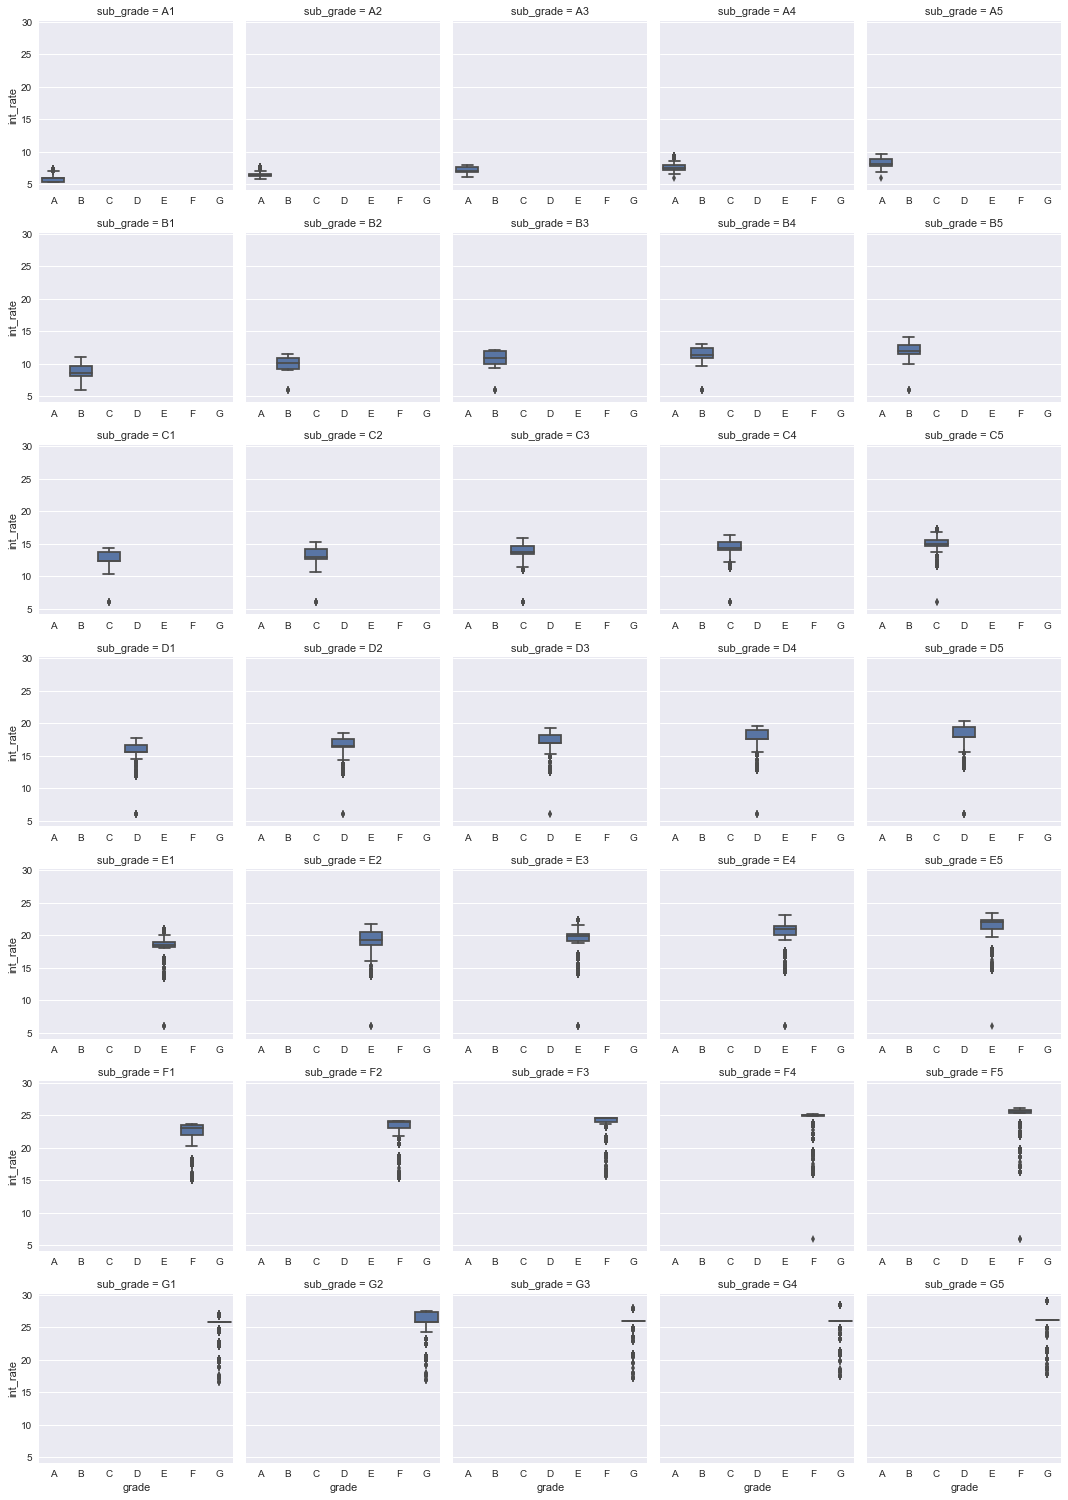

In [ ]:
g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'int_rate')



### Creating customer income range (Binning).
Creating 15 income range bins, used gaussian distribution technique to define the income range. <br> <br>

- Total number of loans grouped by income range and loan status
- Total loan amount by income range and loan status

In [ ]:
loanDF = loanDF.withColumn("annual_inc",loanDF["annual_inc"].cast('float'))

loanDF = loanDF.withColumn("annual_inc_range", when((col("annual_inc") >= -10000) & (col("annual_inc") < 20000), "0-20000")
                           .when((col("annual_inc") >= 20000) & (col("annual_inc") < 40000), "20000-40000")
                          .when((col("annual_inc") >= 40000) & (col("annual_inc") < 60000), "40000-60000")
                          .when((col("annual_inc") >= 60000) & (col("annual_inc") < 80000), "60000-80000")
                          .when((col("annual_inc") >= 80000) & (col("annual_inc") < 100000), "80000-100000")
                          .when((col("annual_inc") >= 100000) & (col("annual_inc") < 120000), "100000-120000")
                          .when((col("annual_inc") >= 120000) & (col("annual_inc") < 140000), "120000-140000")
                          .when((col("annual_inc") >= 140000) & (col("annual_inc") < 160000), "140000-160000")
                          .when((col("annual_inc") >= 160000) & (col("annual_inc") < 180000), "160000-180000")
                          .when((col("annual_inc") >= 180000) & (col("annual_inc") < 200000), "180000-200000")
                          .when((col("annual_inc") >= 200000) & (col("annual_inc") < 250000), "200000-250000")
                          .when((col("annual_inc") >= 250000) & (col("annual_inc") < 500000), "250000-500000")
                          .when((col("annual_inc") >= 500000) & (col("annual_inc") < 1000000), "500000-1000000")
                          .when((col("annual_inc") >= 1000000) & (col("annual_inc") < 5000000), "1000000-5000000")
                          .otherwise(">5000000"))                          

### Analyzing Default loans
Loan status which are in following status will be considered as defaulted - <br>
- Default, Late (31-120 days), 
- In Grace Period, Late (16-30 days), 
- Does not meet the credit policy. 
- Status:Charged Off <br>

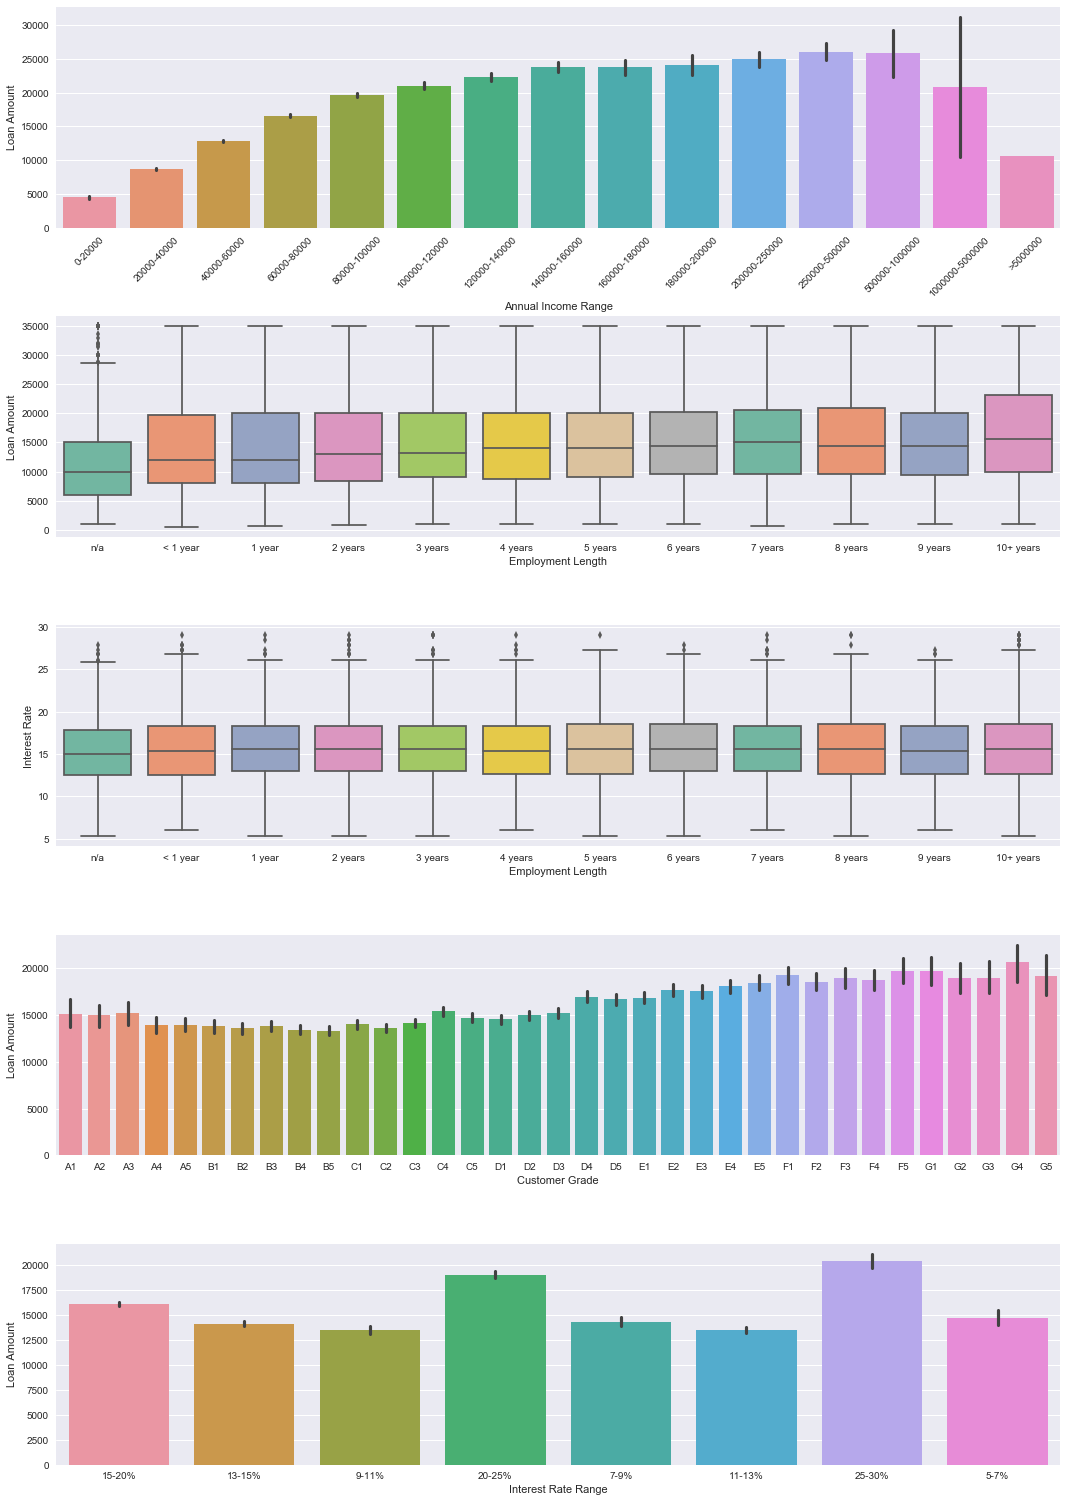

In [ ]:
loanDF.registerTempTable("loanDFTable")

defaultLoanDF = sqlContext.sql("select annual_inc_range, loan_amnt, emp_length, int_rate, sub_grade, int_rate_range  \
from loanDFTable \
where loan_status in ('Default','Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',\
'Does not meet the credit policy. Status:Charged Off')").toPandas()



fig, ax = plt.subplots(5,1, figsize=(18,30))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

incRangeOrder = ["0-20000","20000-40000","40000-60000","60000-80000", "80000-100000", "100000-120000", "120000-140000", 
                "140000-160000", "160000-180000", "180000-200000", "200000-250000", "250000-500000", "500000-1000000",
                "1000000-5000000", ">5000000"]
s0 = sns.barplot(x="annual_inc_range", y="loan_amnt", data=defaultLoanDF, order=incRangeOrder, ax=ax[0])
s0.set(xlabel='Annual Income Range',ylabel='Loan Amount')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

empLengthOrder = ["n/a",'< 1 year','1 year','2 years','3 years','4 years', '5 years','6 years', '7 years', '8 years','9 years','10+ years']

s1 = sns.boxplot(x="emp_length", y="loan_amnt", data=defaultLoanDF, palette="Set2", order=empLengthOrder ,ax=ax[1])
s1.set(xlabel='Employment Length',ylabel='Loan Amount')

s2 = sns.boxplot(x="emp_length", y="int_rate", data=defaultLoanDF, palette="Set2", order=empLengthOrder ,ax=ax[2])
s2.set(xlabel='Employment Length',ylabel='Interest Rate')


subgradeOrder = ["A1", "A2", "A3", "A4", "A5", "B1", "B2", "B3", "B4", "B5", "C1", "C2", "C3", "C4", "C5", "D1", "D2", "D3", "D4", "D5",
                "E1", "E2", "E3", "E4", "E5", "F1", "F2", "F3", "F4", "F5", "G1", "G2", "G3", "G4", "G5"]
s3 = sns.barplot(x="sub_grade", y="loan_amnt", data=defaultLoanDF, order = subgradeOrder, ax=ax[3])
s3.set(xlabel='Customer Grade',ylabel='Loan Amount')

intRateRangeOrder = ["5-7%", "7-9%", "9-11%", "11-13%", "13-15%", "15-20%", "20-25%", "25-30%", ">30%"]
s4 = sns.barplot(x="int_rate_range", y="loan_amnt", data=defaultLoanDF, ax=ax[4])
s4.set(xlabel='Interest Rate Range',ylabel='Loan Amount')

plt.show()

fig.savefig("DefaultLoans.pdf")

### Data Cleaning & Missing Data Imputation

In [ ]:
# Cleaning up the data

# 1. Removing all the features which has more than 50% of the data empty 
missingValueColList = ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
loanDFForModel = loanDF.drop(*missingValueColList)

# 2. Removing unique ID columns 
loanDFForModel = loanDFForModel.drop("id", "member_id", "issue_d")


#3. Missing data imputation for tot_cur_bal  
loanDFForModel = loanDFForModel.withColumn("tot_cur_bal", when((col("tot_cur_bal").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_cur_bal")))

loanDFForModel = loanDFForModel.withColumn("tot_coll_amt", when((col("tot_coll_amt").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_coll_amt")))

#4.Inputing mean value for "total_rev_hi_lim"
mean = int(loanDFForModel.select(avg("total_rev_hi_lim")).take(1)[0][0])
loanDFForModel = loanDFForModel.withColumn("total_rev_hi_lim", when(col("total_rev_hi_lim").isNull(), lit(mean))
                                           .otherwise(col("total_rev_hi_lim")))


#5. Adding the lable column to dataframe. 1- defalut and 0-paid/current 
loanDFForModel = loanDFForModel.withColumn("isDefault", when(col("loan_status").isin("Default","Charged Off", "Late (31-120 days)", "Late (16-30 days)", 
                                                                     "Does not meet the credit policy. Status:Charged Off"), 1)
                           .otherwise(0))


loanDFForModel = loanDFForModel.withColumn("loan_amnt",loanDFForModel["loan_amnt"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("funded_amnt",loanDFForModel["funded_amnt"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("funded_amnt_inv",loanDFForModel["funded_amnt_inv"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("int_rate",loanDFForModel["int_rate"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("installment",loanDFForModel["installment"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("annual_inc",loanDFForModel["annual_inc"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("dti",loanDFForModel["dti"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("delinq_2yrs",loanDFForModel["delinq_2yrs"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("inq_last_6mths",loanDFForModel["inq_last_6mths"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("open_acc",loanDFForModel["open_acc"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("pub_rec",loanDFForModel["pub_rec"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("revol_bal",loanDFForModel["revol_bal"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("revol_util",loanDFForModel["revol_util"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("total_acc",loanDFForModel["total_acc"].cast('float'))

# 6. Removing the fileds which are related to the current loan ########## 
loanDFForModel = loanDFForModel.drop("out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", 
                                     "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
                                    "last_pymnt_amnt", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt",
                                    "tot_cur_bal", "total_rev_hi_lim")



### Converting Categorical feature "emp_lenght" to continous feature

In [ ]:
loanDFForModel = loanDFForModel.withColumn("emp_lengthIndex", when(col("emp_length") == "< 1 year", 0)
                                           .when(col("emp_length") == "1 year", 1)
                                           .when(col("emp_length") == "2 years", 2)
                                           .when(col("emp_length") == "3 years", 3)
                                           .when(col("emp_length") == "4 years", 4)
                                           .when(col("emp_length") == "5 years", 5)
                                           .when(col("emp_length") == "6 years", 6)
                                           .when(col("emp_length") == "7 years", 7)
                                           .when(col("emp_length") == "8 years", 8)
                                           .when(col("emp_length") == "9 years", 9)
                                           .when(col("emp_length") == "10+ years", 10)
                                           .otherwise(0))

In [ ]:
loanDFForModel.groupby("ClassLable").count().show()

+----------+------+
|ClassLable| count|
+----------+------+
|         1| 60153|
|         0|819919|
+----------+------+



### Adding a Weight Column to handle class imbalancing. 

In [ ]:
# Adding a weight columns to the dataset to handel class imbalance
# Hardcoding it to save some execution time - (60153/819919) - (#Default Loans / #Total Loans)
balancingRatio  = 0.0735

loanDFForModel = loanDFForModel.withColumn("weightColumn", when(col("ClassLable") == 0, balancingRatio)
                                           .otherwise((1-balancingRatio)))

#loanDFForModel.groupby("weightColumn").count().show()

### Train/Test split based on the hardcoded seed value (70 : 30)

In [ ]:
# Creating Training and Test set (70% , 30%)
(trainingSetDF, testSetDF) = loanDFTransformed_2.randomSplit([0.7, 0.3], 1395)

trainingSetDF.cache()
testSetDF.cache()



DataFrame[loan_amnt: float, funded_amnt: float, funded_amnt_inv: float, int_rate: float, installment: float, annual_inc: float, dti: float, delinq_2yrs: float, inq_last_6mths: float, open_acc: float, pub_rec: float, revol_bal: float, revol_util: float, total_acc: float, termIndex: double, initial_list_statusIndex: double, application_typeIndex: double, pymnt_planIndex: double, grade_F: int, grade_E: int, grade_B: int, grade_D: int, grade_C: int, grade_A: int, grade_G: int, sub_grade_D5: int, sub_grade_F2: int, sub_grade_B4: int, sub_grade_A2: int, sub_grade_E4: int, sub_grade_B2: int, sub_grade_C3: int, sub_grade_D1: int, sub_grade_C4: int, sub_grade_F1: int, sub_grade_D3: int, sub_grade_F5: int, sub_grade_G2: int, sub_grade_B1: int, sub_grade_B3: int, sub_grade_E5: int, sub_grade_C5: int, sub_grade_G3: int, sub_grade_A4: int, sub_grade_F4: int, sub_grade_B5: int, sub_grade_E3: int, sub_grade_G4: int, sub_grade_D2: int, sub_grade_C1: int, sub_grade_F3: int, sub_grade_E1: int, sub_grade

### Method to compute the model evaluation matrix

In [ ]:
def getEvaluationMatrix(predicDF):
    lablePrediction = predicDF.select( "label", "prediction")
    lablePrediction.cache()
    totalCount = lablePrediction.count()
    correctCount = lablePrediction.filter(col("label") == col("prediction")).count()
    wrongCount = lablePrediction.filter(~(col("label") == col("prediction"))).count()
    trueP = lablePrediction.filter(col("label") == 0.0).filter(col("label") == col("prediction")).count()
    trueN = lablePrediction.filter(col("label") == 1.0).filter(col("label") == col("prediction")).count()
    falseN = lablePrediction.filter(col("label") == 1.0).filter(~(col("label") == col("prediction"))).count()
    falseP = lablePrediction.filter(col("label") == 0.0).filter(~(col("label") == col("prediction"))).count()

    ratioWrong = float(wrongCount) / float(totalCount) 
    ratioCorrect = float(correctCount)/ float(totalCount)

    print("totalCount   - ", totalCount)
    print("correctCount - ", correctCount)
    print("wrongCount   - ", wrongCount)
    print("trueP        - ", trueP)
    print("trueN        - ", trueN)
    print("falseN       - ", falseN)
    print("falseP       - ", falseP)
    print("ratioWrong   - ", ratioWrong)
    print("ratioCorrect - ", ratioCorrect)
    
    precision = ((float(trueP) / (float(trueP) + float(falseP))) * 100 )
    recall = ((float(trueP) / (float(trueP) + float(falseN))) * 100 )
    print("Accuracy     - ", (trueP + trueN) / totalCount)
    print("Precision    - ", precision)
    print("Recall       - ", recall)
    print("F-1 Score    - ", ((2* ( (precision*recall) / (precision + recall))) ))
    print("Sensitivity  - ", ((float(trueP) / (float(trueP) + float(falseN))) * 100 ))
    print("Specificity  - ", ((float(trueN) / (float(trueN) + float(falseP))) * 100 ))
    
    createROC(predictions)
    

### Method to compute the ROC Curve

In [ ]:
def createROC(predictions):
    results = predictions.select(['probability', 'label'])
 
    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
    bcMetrics = BinaryClassificationMetrics(scoreAndLabels)
    print("ROC score is - ", bcMetrics.areaUnderROC)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]
 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression Classifier

**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** 
totalCount   -  264025
correctCount -  251938
wrongCount   -  12087
trueP        -  236174
trueN        -  15764
falseN       -  2375
falseP       -  9712
ratioWrong   -  0.045779755704952185
ratioCorrect -  0.9542202442950478
Accuracy     -  0.9542202442950478
Precision    -  96.05020212618855
Recall       -  99.00439741939812
F-1 Score    -  97.50492842176969
Sensitivity  -  99.00439741939812
Specificity  -  61.87784581566965
ROC score is -  0.9789662436081351


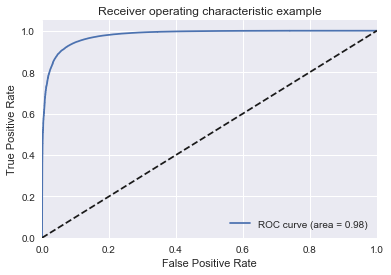

In [ ]:
print("**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** ")

# Create initial LogisticRegression model
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features", maxIter=3, weightCol="weightColumn")
#lr_classifier = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10, weightCol="weightColumn")

# Train model with Training Data
lrModel = lr_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testSetDF)

# Evaluate model
evaluator = BinaryClassificationEvaluator( labelCol="label")
lr_accuracy = evaluator.evaluate(predictions)

#print(lr_accuracy)

getEvaluationMatrix(predictions)